In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) #transforms.Normalize((0.1307,), (0.3081,) - вычитание среднего значения по датасету мнист и деление на стандартное отклонение
])
path = './MNIST_data'
batch_size = 32

In [ ]:
test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [112]:
#create order for bad train dataset 
target_classes = []
while len(target_classes) < 60000:
  for i in range(0, 10):
    target_classes.append(i)

In [113]:
target_classes.sort()

In [114]:
from itertools import cycle


# create cyclic iterators of indices for each class in MNIST
indices = dict()
for label in torch.unique(train_data.targets).tolist():
    indices[label] = cycle(torch.nonzero(train_data.targets == label).flatten().tolist())

# define the order of indices in the new mnist subset based on target_classes
new_indices = []
for t in target_classes:
    n = next(indices[t])
    new_indices.append(n)

# create a Subset of MNIST based on new_indices
mnist_modified = torch.utils.data.Subset(train_data, new_indices)
bad_train_loader = torch.utils.data.DataLoader(mnist_modified, batch_size=32, shuffle=False)

In [6]:
class Net(nn.Module):
    def __init__(self,
                 inner_neurons=128,
                 dropout=False,
                 lr=1e-4, l2=0.0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, inner_neurons)
        self.fc2 = nn.Linear(inner_neurons, inner_neurons)
        self.fc3 = nn.Linear(inner_neurons, 10)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        pred = output.data.max(1, keepdim=True)[1]
        t = target.data.view_as(pred)
        self._correct = pred.eq(t).to(torch.float).mean()
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [59]:
def train(models, device, loader, epoch, log=None):
    train_size = len(loader.sampler)
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss.item(), models[k]._correct))
        print(line + losses)

In [9]:
def test(models, device, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [116]:
models = {'default': Net()}

In [107]:
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [108]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k)
                          for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
        
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k)
                          for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

Train Epoch: 1 [0/60000 (0%)]	Losses default: 2.306557
Train Epoch: 1 [6400/60000 (11%)]	Losses default: 2.268377
Train Epoch: 1 [12800/60000 (21%)]	Losses default: 2.436643
Train Epoch: 1 [19200/60000 (32%)]	Losses default: 2.352147
Train Epoch: 1 [25600/60000 (43%)]	Losses default: 2.367524
Train Epoch: 1 [32000/60000 (53%)]	Losses default: 2.129257
Train Epoch: 1 [38400/60000 (64%)]	Losses default: 2.186332
Train Epoch: 1 [44800/60000 (75%)]	Losses default: 2.409322
Train Epoch: 1 [51200/60000 (85%)]	Losses default: 2.357346
Train Epoch: 1 [57600/60000 (96%)]	Losses default: 2.388309
Train Epoch: 1 [60000/60000 (100%)]	Losses default: 2.313811
Test set:
default: Loss: 2.2556	Accuracy: 1510.0/10000 (15%)

Train Epoch: 2 [0/60000 (0%)]	Losses default: 2.206868
Train Epoch: 2 [6400/60000 (11%)]	Losses default: 2.222841
Train Epoch: 2 [12800/60000 (21%)]	Losses default: 2.343967
Train Epoch: 2 [19200/60000 (32%)]	Losses default: 2.325201
Train Epoch: 2 [25600/60000 (43%)]	Losses default

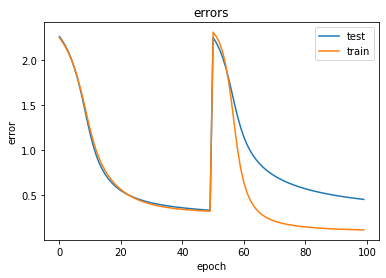

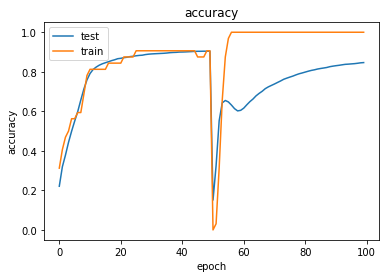

In [117]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
  print('CUDA is available')
for key, model in models.items():
        models[key] = model.train()
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(models, device, bad_train_loader, epoch, train_log)
    for model in models.values():
        model.eval()
    test(models, device, test_loader, test_log)

log = {}
log['test'] = test_log['default']
log['train'] = train_log['default']

plot_graphs(log, 'loss')
plot_graphs(log, 'accuracy')